In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
import warnings
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import initializers
import tensorflow as tf

train = pd.read_csv('train.csv').set_index('id')
test = pd.read_csv('test.csv').set_index('id')

cat_feat = ['Gender', 'Driving_License', 'Vehicle_Damage','Region_Code','Policy_Sales_Channel','Previously_Insured']
binary_cat_feat = ['Gender', 'Driving_License', 'Vehicle_Damage','Previously_Insured']
num_feat = ['Annual_Premium', 'Age', 'Vehicle_Age','Vintage']

train.loc[train['Vehicle_Age'] == '< 1 Year', 'Vehicle_Age'] = 0
train.loc[train['Vehicle_Age'] == '1-2 Year', 'Vehicle_Age'] = 1
train.loc[train['Vehicle_Age'] == '> 2 Years', 'Vehicle_Age'] = 2
train.loc[train['Vehicle_Damage'] == 'Yes','Vehicle_Damage'] = 1
train.loc[train['Vehicle_Damage'] == 'No','Vehicle_Damage'] = 0
train.loc[train['Gender'] == 'Female','Gender'] = 1
train.loc[train['Gender'] == 'Male','Gender'] = 0

test.loc[test['Vehicle_Age'] == '< 1 Year', 'Vehicle_Age'] = 0
test.loc[test['Vehicle_Age'] == '1-2 Year', 'Vehicle_Age'] = 1
test.loc[test['Vehicle_Age'] == '> 2 Years', 'Vehicle_Age'] = 2
test.loc[test['Vehicle_Damage'] == 'Yes','Vehicle_Damage'] = 1
test.loc[test['Vehicle_Damage'] == 'No','Vehicle_Damage'] = 0
test.loc[test['Gender'] == 'Female','Gender'] = 1
test.loc[test['Gender'] == 'Male','Gender'] = 0

# make 6 categories ouf of Regional_Code (keep the 5 most common) and one-hot-encode them.
nb_categories = 20
temp = pd.concat([train,test])
temp['rc'] = temp['Region_Code'].astype(int)
temp.loc[~(temp['rc'].isin(train['Region_Code'].value_counts().index[:nb_categories])),'rc'] = 100
temp = temp.join(pd.get_dummies(temp['rc'],prefix = 'rc')).drop(columns = ['rc_100','rc'])
train = temp.loc[train.index,:].copy()
test = temp.loc[test.index,:].copy()
del temp

# make 4 categories ouf of Policy_Sales_Channel (keep the 3 most common) and one-hot-encode them.
nb_categories = 16
temp = pd.concat([train,test])
temp['psc'] = temp['Policy_Sales_Channel'].astype(int)
temp.loc[~(temp['psc'].isin(train['Policy_Sales_Channel'].value_counts().index[:nb_categories])),'psc'] = 200
temp = temp.join(pd.get_dummies(temp['psc'],prefix = 'psc')).drop(columns = ['psc_200','psc'])
train = temp.loc[train.index,:].copy()
test = temp.loc[test.index,:].copy()
del temp

middle_age = 43.5
n = 0.1
temp = (train['Age'])**n - (middle_age)**n
train['age_lin'] = np.abs(temp)**1.2
temp = (test['Age'])**n - (middle_age)**n
test['age_lin'] = np.abs(temp)**1.2

X_train, X_val, _, _ = train_test_split(train, train['Response'], test_size=0.2)

#print('Remove outliers:',len(X_train[X_train['Annual_Premium']<100000])/len(X_train))
#X_train = X_train[X_train['Annual_Premium']<100000].copy()

print('Remove 1 faulty data point. The Region_Code is an integer.')
X_train = X_train[X_train['Region_Code'] != 39.2]

2024-07-29 15:10:27.962676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Remove 1 faulty data point. The Region_Code is an integer.


In [2]:
# Set up models
class predictor():
    def __init__(self, model, parameters = {}):
        self.model = model
        self.models = ['baseline','random','seperate_obvious','group_averages','log_reg','xgb','catboost']
        self.parameters = parameters
        self.is_not_trained = True
    
    def train(self,X,y):
        if self.model == 'baseline':
            self.mean = y.sum()/len(y)
        if self.model == 'seperate_obvious':
            y = y[(X['Driving_License'] == 1) & (X['Previously_Insured'] == 0) & (X['Age'] < 84)].copy()
            self.mean = y.sum()/len(y)
        if self.model == 'group_averages':
            X = X[(X['Driving_License'] == 1) & (X['Previously_Insured'] == 0) & (X['Age'] < 84)].copy()
            feats = [f for f in cat_feat if not(f in ['Policy_Sales_Channel','Driving_License','Previously_Insured'])]+['Age']
            self.averages = X[feats+['Response']].groupby(feats).sum()/X[feats+['Response']].groupby(feats).count()
        if self.model == 'log_reg':
            class_weight = self.parameters.get('class_weight',None)
            resample = self.parameters.get('resample',False)
            C = self.parameters.get('C',1)
            if resample:
                rus = RandomUnderSampler()
                X, y = rus.fit_resample(X, y)
            scaler = StandardScaler()
            log_reg = LogisticRegression(class_weight = class_weight, C = C)
            log_reg.fit(scaler.fit_transform(X),y)
            self.scaler = scaler
            self.log_reg = log_reg
        if self.model == 'xgb':
            max_depth = self.parameters.get('max_depth',None)
            gamma = self.parameters.get('gamma',None)
            min_child_weight = self.parameters.get('min_child_weight',None)
            resample = self.parameters.get('resample',False)
            class_weight = self.parameters.get('class_weight',None)
            n_estimators = self.parameters.get('n_estimators',None)
            eta = self.parameters.get('eta',None)
            if resample:
                rus = RandomUnderSampler()
                X, y = rus.fit_resample(X, y)
            weights = np.ones(len(y))
            if not(class_weight is None):
                weights[y==0] = class_weight[0]
                weights[y==1] = class_weight[1]
            xgb = XGBClassifier(max_depth = max_depth, gamma = gamma, min_child_weight = min_child_weight, n_estimators = n_estimators, eta = eta)
            xgb.fit(X.astype(float),y,sample_weight = weights)
            self.xgb = xgb
        if self.model == 'catboost':
            resample = self.parameters.get('resample',False)
            class_weight = self.parameters.get('class_weight',None)
            n_estimators = self.parameters.get('n_estimators',None)
            max_depth = self.parameters.get('max_depth',None)
            eta = self.parameters.get('eta',None)
            if resample:
                rus = RandomUnderSampler()
                X, y = rus.fit_resample(X, y)
            weights = np.ones(len(y))
            if not(class_weight is None):
                weights[y==0] = class_weight[0]
                weights[y==1] = class_weight[1]
            catb = CatBoostClassifier(n_estimators = n_estimators,max_depth = max_depth, eta = eta)
            catb.fit(X.astype(float),y,sample_weight = weights,verbose=False)
            self.catb = catb
        self.is_not_trained = False

    def predict(self,X):
        if self.model == 'baseline':
            self.prediction = np.full(len(X),self.mean)
            return np.full(len(X),self.mean)
        if self.model == 'random':
            self.prediction = np.random.rand(len(X))
            return self.prediction
        if self.model == 'seperate_obvious':
            X.loc[(X['Driving_License'] == 1) & (X['Previously_Insured'] == 0) & (X['Age'] < 84),'prob_pred'] = self.mean
            X.loc[~((X['Driving_License'] == 1) & (X['Previously_Insured'] == 0) & (X['Age'] < 84)),'prob_pred'] = 0
            self.prediction = X['prob_pred'].values
            return X['prob_pred'].values
        if self.model == 'group_averages':
            X.loc[~((X['Driving_License'] == 1) & (X['Previously_Insured'] == 0) & (X['Age'] < 84)),'prob_pred'] = 0
            for group in self.averages.index:
                X.loc[((X['Driving_License'] == 1) & (X['Previously_Insured'] == 0) & (X['Age'] < 84) & (X['Gender'] == group[0]) &
                        (X['Driving_License'] == group[1]) & (X['Vehicle_Damage'] == group[2]) & (X['Region_Code'] == group[3])),'prob_pred'] = self.averages.loc[group,'Response']
            self.prediction = X['prob_pred'].values
            return X['prob_pred'].values
        if self.model == 'log_reg':
            self.prediction = self.log_reg.predict_proba(self.scaler.transform(X))[:,1]
            return self.prediction
        if self.model == 'xgb':
            self.prediction = self.xgb.predict_proba(X.astype(float))[:,1]
            return self.prediction
        if self.model == 'catboost':
            self.prediction = self.catb.predict_proba(X.astype(float))[:,1]
            return self.prediction
        
    def validate(self,X,y):
        X = X.copy()
        y = y.copy()
        nb_samples = self.parameters.get('nb_samples',5)
        data_set_portion = self.parameters.get('data_set_portion',1)
        if data_set_portion < 1:
            X['Response'] = y.copy()
            X = X.sample(frac = data_set_portion)
            y = X['Response'].copy()
            X = X.drop(columns = 'Response')
        scores = pd.DataFrame([],columns=['score','seed'],index = np.arange(nb_samples))
        for sample in range(nb_samples):
            seed = sample
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = seed)
            self.train(X_train,y_train)
            scores.loc[sample,['score', 'seed']] = [roc_auc_score(y_val,self.predict(X_val)),seed]
        scores.loc['mean/std',:] = [scores['score'].mean(),scores['score'].std()]
        return scores

# Dumb models

In [ ]:
baseline = predictor('seperate_obvious',{'nb_samples': 10, 'data_set_portion': 0.1})
baseline.train(X_train,X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],baseline.predict(X_val)))
print('Submitted, score:',0.76286)
display(baseline.validate(X_train,X_train['Response']))
pd.DataFrame(baseline.predict(test),index = test.index,columns = ['Response']).to_csv('submission.csv')

My score: 0.7629123143288514
Submitted, score: 0.76286


,score,seed
0,0.762796,0
1,0.763766,1
2,0.762787,2
3,0.763504,3
4,0.76362,4
5,0.763081,5
6,0.76315,6
7,0.764078,7
8,0.762831,8
9,0.763206,9


In [ ]:
# This takes a very long time to train and predict. Not worth it.
group_averages = predictor('group_averages')
group_averages.train(X_train,X_train['Response'])
#roc_auc_score(X_val['Response'],group_averages.predict(X_val))
#pd.DataFrame(group_averages.predict(test),index = test.index,columns = ['Response']).to_csv('submission.csv')
print('My score:',0.7945739814266146)
print('Submitted, score:',0.76847)

My score: 0.7945739814266146
Submitted, score: 0.76847


# Logistic regression

0.07      777777778       


,score
0.048333,0.836879
0.041111,0.836879
0.050000,0.836879
0.052222,0.836878
0.055556,0.836877


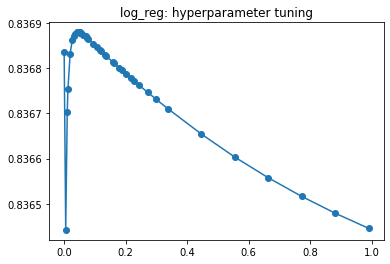

In [ ]:
nb = np.linspace(0.005,0.07,10)
#parameter_tuning = pd.DataFrame([],index = [-1]+nb,columns = ['score'])
#parameter_tuning.loc[0,'score'] = 0.83683511968046
for n in nb:
    print(n, end = '      \r')
    log_reg = predictor('log_reg',{'class_weight':{0:n,1:1-n}})
    log_reg.train(X_train[num_feat+cat_feat],X_train['Response'])
    parameter_tuning.loc[n,'score'] = roc_auc_score(X_val['Response'],log_reg.predict(X_val[num_feat+cat_feat]))
parameter_tuning = parameter_tuning.sort_index()
plt.scatter(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score'])
plt.title('log_reg: hyperparameter tuning')
print()
display(parameter_tuning.sort_values('score',ascending = False).head(5))

In [ ]:
log_reg = predictor('log_reg',{'class_weight':{0:0.048333,1:1-0.048333},'nb_samples': 10, 'data_set_portion': 0.25})
log_reg.train(X_train[num_feat+cat_feat],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],log_reg.predict(X_val[num_feat+cat_feat])))
log_reg.validate(X_train[num_feat+cat_feat],X_train['Response'])

My score: 0.8366808699728884


,score,seed
0,0.83598,0
1,0.836318,1
2,0.835821,2
3,0.835996,3
4,0.835373,4
5,0.835993,5
6,0.836302,6
7,0.836601,7
8,0.836888,8
9,0.837325,9


In [ ]:
log_reg = predictor('log_reg',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
log_reg.train(X_train[num_feat+cat_feat],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],log_reg.predict(X_val[num_feat+cat_feat])))
log_reg.validate(X_train[num_feat+cat_feat],X_train['Response'])

My score: 0.8366548541416787


,score,seed
0,0.836609,0
1,0.836364,1
2,0.837288,2
3,0.837348,3
4,0.835824,4
5,0.835856,5
6,0.836403,6
7,0.837867,7
8,0.83647,8
9,0.837076,9


Resampling does the same job as selecting the optimal class_weight.

100.0      1685144         


,score,std
29.763514,0.837893,0.00125
688.947368,0.83775,0.000464
0.127427,0.837708,0.000834
206.913808,0.837674,0.000633
0.150526,0.837658,0.000907


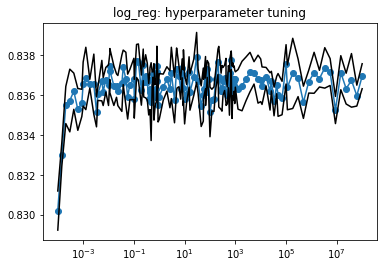

In [ ]:
#nb = np.linspace(0.00001,0.1,20)
nb = np.logspace(-3,2,20)
#parameter_tuning = pd.DataFrame([],index = nb,columns = ['score','std'])
for n in nb:
    print(n, end = '      \r')
    log_reg = predictor('log_reg',{'resample': True, 'C':n, 'nb_samples': 5, 'data_set_portion': 0.1})
    log_reg.train(X_train[num_feat+cat_feat],X_train['Response'])
    parameter_tuning.loc[n,['score','std']] = log_reg.validate(X_train[num_feat+cat_feat],X_train['Response']).loc['mean/std',:].values
parameter_tuning = parameter_tuning.sort_index()
plt.scatter(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score']+parameter_tuning['std'], color = 'k')
plt.plot(parameter_tuning.index,parameter_tuning['score']-parameter_tuning['std'], color = 'k')
plt.title('log_reg: hyperparameter tuning')
plt.xscale('log')
print()
display(parameter_tuning.sort_values('score',ascending = False).head(5))

It looks like there is no need for regularisation.

In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
log_reg = predictor('log_reg',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
log_reg.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],log_reg.predict(X_val[feat_to_use])))
log_reg.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.8366316279864778


,score,seed
0,0.837341,0
1,0.837378,1
2,0.837248,2
3,0.837208,3
4,0.837085,4
5,0.836377,5
6,0.836949,6
7,0.837628,7
8,0.836612,8
9,0.837219,9


In [ ]:
feat_to_use = [f for f in num_feat+cat_feat if not(f in ['Region_Code','Policy_Sales_Channel'])] + [c for c in X_train.columns if c.startswith('rc')] + [c for c in X_train.columns if c.startswith('psc')]
print(feat_to_use)
log_reg = predictor('log_reg',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
log_reg.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],log_reg.predict(X_val[feat_to_use])))
log_reg.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Previously_Insured', 'rc_8', 'rc_15', 'rc_28', 'rc_41', 'rc_46', 'psc_26', 'psc_124', 'psc_152']
My score: 0.8434973164833791


,score,seed
0,0.843907,0
1,0.843944,1
2,0.843682,2
3,0.842855,3
4,0.843191,4
5,0.844103,5
6,0.843816,6
7,0.843841,7
8,0.843014,8
9,0.843707,9


In [ ]:
feat_to_use = num_feat+cat_feat + [c for c in X_train.columns if c.startswith('rc')] + [c for c in X_train.columns if c.startswith('psc')]
print(feat_to_use)
log_reg = predictor('log_reg',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
log_reg.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],log_reg.predict(X_val[feat_to_use])))
log_reg.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured', 'rc_8', 'rc_15', 'rc_28', 'rc_41', 'rc_46', 'psc_26', 'psc_124', 'psc_152']
My score: 0.8438339994081632


,score,seed
0,0.844162,0
1,0.845071,1
2,0.843859,2
3,0.844165,3
4,0.844482,4
5,0.844109,5
6,0.842611,6
7,0.843463,7
8,0.844126,8
9,0.843515,9


It helps to partially one-hot encode 'Region_Code','Policy_Sales_Channel'. Then we might as well remove 'Region_Code','Policy_Sales_Channel' they don't affect the score.

In [ ]:
feat_to_use = [f for f in num_feat+cat_feat if not(f in ['Region_Code','Policy_Sales_Channel','Age'])] + [c for c in X_train.columns if c.startswith('rc')] + [c for c in X_train.columns if c.startswith('psc')]
print(feat_to_use)
log_reg = predictor('log_reg',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
log_reg.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],log_reg.predict(X_val[feat_to_use])))
log_reg.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Previously_Insured', 'rc_8', 'rc_15', 'rc_28', 'rc_41', 'rc_46', 'psc_26', 'psc_124', 'psc_152']
My score: 0.8309730762292408


,score,seed
0,0.830747,0
1,0.830833,1
2,0.831712,2
3,0.830947,3
4,0.83155,4
5,0.831787,5
6,0.830459,6
7,0.831607,7
8,0.831675,8
9,0.830772,9


In [ ]:
feat_to_use = [f for f in num_feat+cat_feat if not(f in ['Region_Code','Policy_Sales_Channel'])] + [c for c in X_train.columns if c.startswith('rc')] + [c for c in X_train.columns if c.startswith('psc')]+['age_lin']
print(feat_to_use)
log_reg = predictor('log_reg',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
log_reg.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],log_reg.predict(X_val[feat_to_use])))
log_reg.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Previously_Insured', 'rc_8', 'rc_15', 'rc_28', 'rc_41', 'rc_46', 'psc_26', 'psc_124', 'psc_152', 'age_lin']
My score: 0.8489723063459459


,score,seed
0,0.848979,0
1,0.848566,1
2,0.849448,2
3,0.84868,3
4,0.850584,4
5,0.849238,5
6,0.84982,6
7,0.849725,7
8,0.849013,8
9,0.84941,9


Transforming the Age feature helps, but Age must be kept in.

In [ ]:
feat_to_use = [f for f in num_feat+cat_feat if not(f in ['Region_Code','Policy_Sales_Channel'])] + [c for c in X_train.columns if c.startswith('rc')] + [c for c in X_train.columns if c.startswith('psc')]+['age_lin']
print(feat_to_use)
log_reg = predictor('log_reg',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
log_reg.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],log_reg.predict(X_val[feat_to_use])))
log_reg.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Previously_Insured', 'rc_8', 'rc_11', 'rc_15', 'rc_28', 'rc_29', 'rc_30', 'rc_36', 'rc_41', 'rc_46', 'rc_50', 'psc_26', 'psc_122', 'psc_124', 'psc_152', 'psc_154', 'psc_156', 'psc_157', 'psc_160', 'age_lin']
My score: 0.8529747367545095


,score,seed
0,0.853289,0
1,0.853544,1
2,0.8526,2
3,0.852521,3
4,0.85357,4
5,0.853377,5
6,0.853399,6
7,0.853143,7
8,0.852509,8
9,0.852586,9


In [ ]:
feat_to_use = [f for f in num_feat+cat_feat if not(f in ['Region_Code','Policy_Sales_Channel'])] + [c for c in X_train.columns if c.startswith('rc')] + [c for c in X_train.columns if c.startswith('psc')]+['age_lin']
print(feat_to_use)
log_reg = predictor('log_reg',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
log_reg.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],log_reg.predict(X_val[feat_to_use])))
log_reg.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Previously_Insured', 'rc_3', 'rc_6', 'rc_8', 'rc_11', 'rc_14', 'rc_15', 'rc_18', 'rc_28', 'rc_29', 'rc_30', 'rc_33', 'rc_35', 'rc_36', 'rc_37', 'rc_39', 'rc_41', 'rc_45', 'rc_46', 'rc_47', 'rc_50', 'psc_7', 'psc_8', 'psc_13', 'psc_25', 'psc_26', 'psc_30', 'psc_55', 'psc_122', 'psc_124', 'psc_151', 'psc_152', 'psc_154', 'psc_156', 'psc_157', 'psc_160', 'psc_163', 'age_lin']
My score: 0.8549979599565805


,score,seed
0,0.854715,0
1,0.85502,1
2,0.855095,2
3,0.854747,3
4,0.854701,4
5,0.854982,5
6,0.854262,6
7,0.854479,7
8,0.856139,8
9,0.854986,9


It helps to include more features in the one-hot encoding. There are however diminishing returns.

# XGB

In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
xgb = predictor('xgb',{'nb_samples': 10, 'data_set_portion': 0.25})
xgb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
xgb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.879080509606373


,score,seed
0,0.87913,0
1,0.878825,1
2,0.877715,2
3,0.879831,3
4,0.878797,4
5,0.878698,5
6,0.879502,6
7,0.878416,7
8,0.878502,8
9,0.87917,9


In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
xgb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
xgb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.8801162880150085


,score,seed
0,0.878025,0
1,0.879282,1
2,0.877075,2
3,0.877963,3
4,0.876854,4
5,0.877812,5
6,0.878636,6
7,0.876691,7
8,0.877604,8
9,0.878447,9


Including resampling makes everything much faster. Without the resampling, the score is slightly better, but it's not worth the 5 times increase in evaluation time.

In [ ]:
feat_to_use = [f for f in num_feat+cat_feat if not(f in ['Age'])]+['age_lin']
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
xgb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
xgb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured', 'age_lin']
My score: 0.8795056044849311


,score,seed
0,0.87579,0
1,0.877028,1
2,0.877019,2
3,0.876287,3
4,0.876551,4
5,0.877585,5
6,0.876776,6
7,0.876557,7
8,0.87646,8
9,0.876238,9


In [ ]:
feat_to_use = num_feat+cat_feat+['age_lin']
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
xgb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
xgb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured', 'age_lin']
My score: 0.8801566559579798


,score,seed
0,0.877677,0
1,0.876352,1
2,0.876721,2
3,0.878274,3
4,0.877023,4
5,0.877524,5
6,0.877547,6
7,0.876193,7
8,0.877402,8
9,0.877959,9


Including age_lin helps does not make a difference.

In [ ]:
feat_to_use = [f for f in num_feat+cat_feat if not(f in ['Region_Code','Policy_Sales_Channel'])] + [c for c in X_train.columns if c.startswith('rc')] + [c for c in X_train.columns if c.startswith('psc')]
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
xgb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
xgb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Previously_Insured', 'rc_3', 'rc_6', 'rc_8', 'rc_11', 'rc_14', 'rc_15', 'rc_18', 'rc_28', 'rc_29', 'rc_30', 'rc_33', 'rc_35', 'rc_36', 'rc_37', 'rc_39', 'rc_41', 'rc_45', 'rc_46', 'rc_47', 'rc_50', 'psc_7', 'psc_8', 'psc_13', 'psc_25', 'psc_26', 'psc_30', 'psc_55', 'psc_122', 'psc_124', 'psc_151', 'psc_152', 'psc_154', 'psc_156', 'psc_157', 'psc_160', 'psc_163']
My score: 0.8785376952406951


,score,seed
0,0.87692,0
1,0.876345,1
2,0.87662,2
3,0.876396,3
4,0.876781,4
5,0.877277,5
6,0.876625,6
7,0.876405,7
8,0.875956,8
9,0.87677,9


In [ ]:
feat_to_use = num_feat+cat_feat + [c for c in X_train.columns if c.startswith('rc')] + [c for c in X_train.columns if c.startswith('psc')]
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25})
xgb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
xgb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured', 'rc_3', 'rc_6', 'rc_8', 'rc_11', 'rc_14', 'rc_15', 'rc_18', 'rc_28', 'rc_29', 'rc_30', 'rc_33', 'rc_35', 'rc_36', 'rc_37', 'rc_39', 'rc_41', 'rc_45', 'rc_46', 'rc_47', 'rc_50', 'psc_7', 'psc_8', 'psc_13', 'psc_25', 'psc_26', 'psc_30', 'psc_55', 'psc_122', 'psc_124', 'psc_151', 'psc_152', 'psc_154', 'psc_156', 'psc_157', 'psc_160', 'psc_163']
My score: 0.8797950051469813


,score,seed
0,0.876849,0
1,0.8777,1
2,0.876863,2
3,0.876954,3
4,0.87803,4
5,0.878204,5
6,0.876621,6
7,0.877529,7
8,0.876284,8
9,0.877448,9


Including the one-hot-encoding does not help.

260            


,score,std
250.0,0.878789,0.000795
225.0,0.878519,0.000623
200.0,0.878152,0.000566
175.0,0.878093,0.000741
100.0,0.878056,0.000543


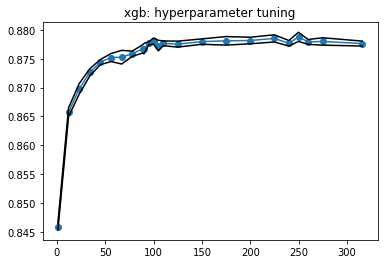

In [ ]:
#nb = np.linspace(1,100,10)
nb = np.logspace(2.5,4,10)
nb = [90,95,105,110,240,260]
#parameter_tuning = pd.DataFrame([],index = nb,columns = ['score','std'])
for n in nb:
    n = int(n)
    print(n, end = '            \r')
    xgb = predictor('xgb',{'resample': True, 'nb_samples': 5, 'data_set_portion': 0.2, 'n_estimators': n})
    xgb.train(X_train[num_feat+cat_feat],X_train['Response'])
    parameter_tuning.loc[n,['score','std']] = xgb.validate(X_train[num_feat+cat_feat],X_train['Response']).loc['mean/std',:].values
parameter_tuning = parameter_tuning.sort_index()
plt.scatter(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score']+parameter_tuning['std'], color = 'k')
plt.plot(parameter_tuning.index,parameter_tuning['score']-parameter_tuning['std'], color = 'k')
plt.title('xgb: hyperparameter tuning')
print()
display(parameter_tuning.sort_values('score',ascending = False).head(5))

,score,std
250.0,0.878789,0.000795
225.0,0.878519,0.000623
200.0,0.878152,0.000566
175.0,0.878093,0.000741
100.0,0.878056,0.000543


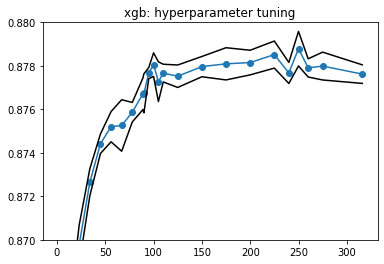

In [ ]:
parameter_tuning = parameter_tuning.sort_index()
plt.scatter(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score']+parameter_tuning['std'], color = 'k')
plt.plot(parameter_tuning.index,parameter_tuning['score']-parameter_tuning['std'], color = 'k')
plt.title('xgb: hyperparameter tuning')
plt.ylim([0.87,0.88])
print()
display(parameter_tuning.sort_values('score',ascending = False).head(5))

Increasing n_estimators improves the model, but slows everything down. We get a saturation around 200. Leave it at 100 for now.

15            


,score,std
7.0,0.877538,0.000615
6.0,0.876777,0.000711
8.0,0.876505,0.000453
5.0,0.876009,0.000565
9.0,0.875864,0.000611


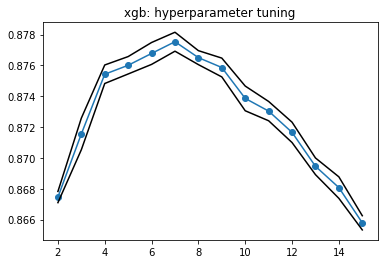

In [ ]:
nb = np.linspace(2,15,14)
parameter_tuning = pd.DataFrame([],index = nb,columns = ['score','std'])
for n in nb:
    n = int(n)
    print(n, end = '            \r')
    xgb = predictor('xgb',{'resample': True, 'nb_samples': 5, 'data_set_portion': 0.2, 'n_estimators': 100, 'max_depth': n})
    xgb.train(X_train[num_feat+cat_feat],X_train['Response'])
    parameter_tuning.loc[n,['score','std']] = xgb.validate(X_train[num_feat+cat_feat],X_train['Response']).loc['mean/std',:].values
parameter_tuning = parameter_tuning.sort_index()
plt.scatter(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score']+parameter_tuning['std'], color = 'k')
plt.plot(parameter_tuning.index,parameter_tuning['score']-parameter_tuning['std'], color = 'k')
plt.title('xgb: hyperparameter tuning')
print()
display(parameter_tuning.sort_values('score',ascending = False).head(5))

In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25, 'n_estimators': 100, 'max_depth': 7})
xgb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
xgb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.8812952828947386


,score,seed
0,0.877567,0
1,0.878242,1
2,0.878168,2
3,0.878386,3
4,0.877811,4
5,0.878002,5
6,0.87796,6
7,0.877998,7
8,0.87789,8
9,0.878782,9


0.1                


,score,std
0.227778,0.877098,0.000415
0.305556,0.877049,0.000587
0.340000,0.876989,0.000829
0.266667,0.876939,0.000492
0.188889,0.876807,0.000591


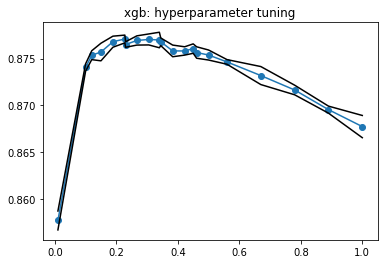

In [ ]:
nb = [0.1]
#parameter_tuning = pd.DataFrame([],index = nb,columns = ['score','std'])
for n in nb:
    print(n, end = '                \r')
    xgb = predictor('xgb',{'resample': True, 'nb_samples': 5, 'data_set_portion': 0.2, 'n_estimators': 100, 'max_depth': 7, 'eta': n})
    xgb.train(X_train[num_feat+cat_feat],X_train['Response'])
    parameter_tuning.loc[n,['score','std']] = xgb.validate(X_train[num_feat+cat_feat],X_train['Response']).loc['mean/std',:].values
parameter_tuning = parameter_tuning.sort_index()
plt.scatter(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score']+parameter_tuning['std'], color = 'k')
plt.plot(parameter_tuning.index,parameter_tuning['score']-parameter_tuning['std'], color = 'k')
plt.title('xgb: hyperparameter tuning')
print()
display(parameter_tuning.sort_values('score',ascending = False).head(5))

In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25, 'n_estimators': 100, 'max_depth': 7, 'eta': 0.227778})
xgb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
xgb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.8800126384968315


,score,seed
0,0.877378,0
1,0.877309,1
2,0.877534,2
3,0.877711,3
4,0.876059,4
5,0.877471,5
6,0.878142,6
7,0.877186,7
8,0.877328,8
9,0.877781,9


25.0                              


,score,std
4.445556,0.877742,0.000767
1.673333,0.877691,0.000454
3.534483,0.877617,0.000509
0.010000,0.877573,0.000442
2.782222,0.877531,0.000967


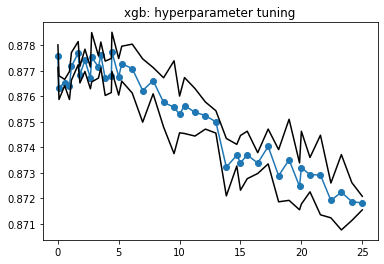

In [ ]:
nb = list(np.linspace(0.1,25,30))
#parameter_tuning = pd.DataFrame([],index = nb,columns = ['score','std'])
for n in nb:
    print(n, end = '                \r')
    xgb = predictor('xgb',{'resample': True, 'nb_samples': 5, 'data_set_portion': 0.2, 'n_estimators': 100, 'max_depth': 7, 'eta': 0.227778, 'gamma': n})
    xgb.train(X_train[num_feat+cat_feat],X_train['Response'])
    parameter_tuning.loc[n,['score','std']] = xgb.validate(X_train[num_feat+cat_feat],X_train['Response']).loc['mean/std',:].values
parameter_tuning = parameter_tuning.sort_index()
plt.scatter(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score']+parameter_tuning['std'], color = 'k')
plt.plot(parameter_tuning.index,parameter_tuning['score']-parameter_tuning['std'], color = 'k')
plt.title('xgb: hyperparameter tuning')
print()
display(parameter_tuning.sort_values('score',ascending = False).head(5))

In [ ]:
gamma_optimal = parameter_tuning.sort_values('score',ascending = False).index[0]

120.0                             


,score,std
68.575714,0.878065,0.000266
78.370816,0.87801,0.000683
80.819592,0.878006,0.000805
66.126939,0.877986,0.000385
46.536735,0.877918,0.000679


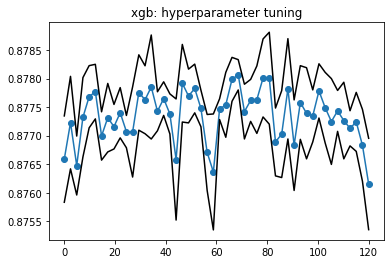

In [ ]:
nb = np.linspace(0.01,120,50)
parameter_tuning = pd.DataFrame([],index = nb,columns = ['score','std'])
for n in nb:
    print(n, end = '                \r')
    xgb = predictor('xgb',{'resample': True, 'nb_samples': 5, 'data_set_portion': 0.2, 'n_estimators': 100, 'max_depth': 7, 'eta': 0.227778, 'gamma': gamma_optimal, 'min_child_weight': n})
    xgb.train(X_train[num_feat+cat_feat],X_train['Response'])
    parameter_tuning.loc[n,['score','std']] = xgb.validate(X_train[num_feat+cat_feat],X_train['Response']).loc['mean/std',:].values
parameter_tuning = parameter_tuning.sort_index()
plt.scatter(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score']+parameter_tuning['std'], color = 'k')
plt.plot(parameter_tuning.index,parameter_tuning['score']-parameter_tuning['std'], color = 'k')
plt.title('xgb: hyperparameter tuning')
print()
display(parameter_tuning.sort_values('score',ascending = False).head(5))

,score,std
73.473265,0.877819,0.000511
71.024490,0.877753,0.000477
68.575714,0.877675,0.000405
75.922041,0.877663,0.000541
80.819592,0.877571,0.000668


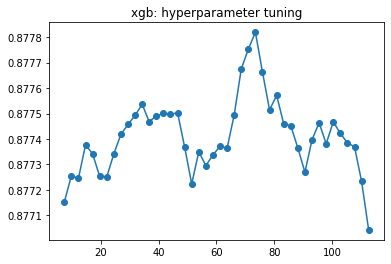

In [ ]:
win = 7
plt.scatter(parameter_tuning.index,parameter_tuning.rolling(window = win,center = True).mean()['score'])
plt.plot(parameter_tuning.index,parameter_tuning.rolling(window = win,center = True).mean()['score'])
plt.title('xgb: hyperparameter tuning')
print()
display(parameter_tuning.rolling(window = win,center = True).mean().sort_values('score',ascending = False).head(5))

In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25, 'n_estimators': 100, 'max_depth': 7, 'gamma': 4.445556, 'min_child_weight': 68.575714})
xgb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
xgb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.881255153410334


,score,seed
0,0.878266,0
1,0.877771,1
2,0.879234,2
3,0.878896,3
4,0.878719,4
5,0.877436,5
6,0.877833,6
7,0.878033,7
8,0.879127,8
9,0.877573,9


In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25, 'n_estimators': 100, 'max_depth': 7, 'gamma': 4.445556, 'min_child_weight': 68.575714})
xgb.train(train[feat_to_use],train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
pd.DataFrame(xgb.predict(test[feat_to_use]),index = test.index,columns = ['Response']).to_csv('submission.csv')
print('Submitted, score:',0.88187)

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.882364935981077
Submitted, score: 0.88187


In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25, 'n_estimators': 100, 'max_depth': 7, 'gamma': 4.445556, 'min_child_weight': 68.575714})
xgb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
xgb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.88120549669625


,score,seed
0,0.879167,0
1,0.876421,1
2,0.877047,2
3,0.877599,3
4,0.877858,4
5,0.878044,5
6,0.877725,6
7,0.878064,7
8,0.878254,8
9,0.878678,9


In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25, 'n_estimators': 250, 'max_depth': 7, 'gamma': 4.445556, 'min_child_weight': 68.575714})
xgb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
xgb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.8816701091234327


,score,seed
0,0.877106,0
1,0.878871,1
2,0.877371,2
3,0.87905,3
4,0.875994,4
5,0.877951,5
6,0.878353,6
7,0.8777,7
8,0.877125,8
9,0.878454,9


In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25, 'n_estimators': 100, 'max_depth': 7, 'gamma': 4.445556, 'min_child_weight': 68.575714})
xgb.train(train[feat_to_use],train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
pd.DataFrame(xgb.predict(test[feat_to_use]),index = test.index,columns = ['Response']).to_csv('submission.csv')
print('Submitted, score:',0.88163)

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.8820990973628797
Submitted, score: 0.88163


In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25, 'n_estimators': 250, 'max_depth': 7, 'gamma': 4.445556, 'min_child_weight': 68.575714})
xgb.train(train[feat_to_use],train['Response'])
print('My score:',roc_auc_score(X_val['Response'],xgb.predict(X_val[feat_to_use])))
pd.DataFrame(xgb.predict(test[feat_to_use]),index = test.index,columns = ['Response']).to_csv('submission.csv')
print('Submitted, score:',0.88475)

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.8847697541670926
Submitted, score: 0.88475


# Catboost

In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
catb = predictor('catboost',{'resample': True,'nb_samples': 10, 'data_set_portion': 0.25})
catb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],catb.predict(X_val[feat_to_use])))
catb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.8801028236862887


,score,seed
0,0.878247,0
1,0.87701,1
2,0.877515,2
3,0.877026,3
4,0.877157,4
5,0.87772,5
6,0.877171,6
7,0.878043,7
8,0.877088,8
9,0.876474,9


In [ ]:
feat_to_use = [f for f in num_feat+cat_feat if not(f in ['Age'])]+['age_lin']
print(feat_to_use)
catb = predictor('catboost',{'resample': True,'nb_samples': 10, 'data_set_portion': 0.25})
catb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],catb.predict(X_val[feat_to_use])))
catb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured', 'age_lin']
My score: 0.879809468534388


,score,seed
0,0.87678,0
1,0.876155,1
2,0.87652,2
3,0.876528,3
4,0.877112,4
5,0.876371,5
6,0.876396,6
7,0.876387,7
8,0.877409,8
9,0.876223,9


In [ ]:
feat_to_use = num_feat+cat_feat+['age_lin']
print(feat_to_use)
catb = predictor('catboost',{'resample': True,'nb_samples': 10, 'data_set_portion': 0.25})
catb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],catb.predict(X_val[feat_to_use])))
catb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured', 'age_lin']
My score: 0.8799144032358676


,score,seed
0,0.877321,0
1,0.876935,1
2,0.878085,2
3,0.877229,3
4,0.877865,4
5,0.877873,5
6,0.878363,6
7,0.876861,7
8,0.877799,8
9,0.877961,9


Including age_lin does not help in any way.

In [ ]:
feat_to_use = [f for f in num_feat+cat_feat if not(f in ['Region_Code','Policy_Sales_Channel'])] + [c for c in X_train.columns if c.startswith('rc')] + [c for c in X_train.columns if c.startswith('psc')]
print(feat_to_use)
catb = predictor('catboost',{'resample': True,'nb_samples': 10, 'data_set_portion': 0.25})
catb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],catb.predict(X_val[feat_to_use])))
catb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Previously_Insured', 'rc_3', 'rc_6', 'rc_8', 'rc_11', 'rc_14', 'rc_15', 'rc_18', 'rc_28', 'rc_29', 'rc_30', 'rc_33', 'rc_35', 'rc_36', 'rc_37', 'rc_39', 'rc_41', 'rc_45', 'rc_46', 'rc_47', 'rc_50', 'psc_7', 'psc_8', 'psc_13', 'psc_25', 'psc_26', 'psc_30', 'psc_55', 'psc_122', 'psc_124', 'psc_151', 'psc_152', 'psc_154', 'psc_156', 'psc_157', 'psc_160', 'psc_163']
My score: 0.8788499960676659


,score,seed
0,0.875712,0
1,0.875586,1
2,0.87647,2
3,0.876926,3
4,0.876708,4
5,0.876677,5
6,0.876054,6
7,0.876243,7
8,0.876073,8
9,0.876817,9


In [ ]:
feat_to_use = num_feat+cat_feat + [c for c in X_train.columns if c.startswith('rc')] + [c for c in X_train.columns if c.startswith('psc')]
print(feat_to_use)
catb = predictor('catboost',{'resample': True,'nb_samples': 10, 'data_set_portion': 0.25})
catb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],catb.predict(X_val[feat_to_use])))
catb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured', 'rc_3', 'rc_6', 'rc_8', 'rc_11', 'rc_14', 'rc_15', 'rc_18', 'rc_28', 'rc_29', 'rc_30', 'rc_33', 'rc_35', 'rc_36', 'rc_37', 'rc_39', 'rc_41', 'rc_45', 'rc_46', 'rc_47', 'rc_50', 'psc_7', 'psc_8', 'psc_13', 'psc_25', 'psc_26', 'psc_30', 'psc_55', 'psc_122', 'psc_124', 'psc_151', 'psc_152', 'psc_154', 'psc_156', 'psc_157', 'psc_160', 'psc_163']
My score: 0.879953329223336


,score,seed
0,0.877113,0
1,0.877505,1
2,0.87744,2
3,0.877306,3
4,0.876575,4
5,0.87672,5
6,0.877491,6
7,0.876813,7
8,0.877693,8
9,0.877769,9


Including the one-hot-encoded features does not help.

1000            


,score,std
599.0,0.877319,0.000839
774.0,0.877054,0.000618
1000.0,0.876921,0.000583
215.0,0.876269,0.000303
359.0,0.876246,0.000494


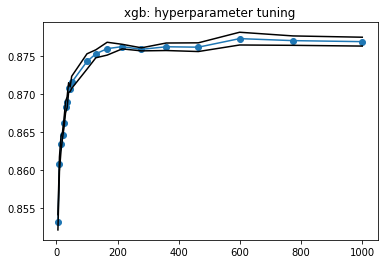

In [ ]:
feat_to_use = num_feat+cat_feat
nb = np.logspace(2,3,10)
#nb = np.logspace(2.5,4,10)
#nb = [90,95,105,110,240,260]
#parameter_tuning = pd.DataFrame([],index = nb,columns = ['score','std'])
for n in nb:
    n = int(n)
    print(n, end = '            \r')
    catb = predictor('catboost',{'resample': True, 'nb_samples': 5, 'data_set_portion': 0.2, 'n_estimators': n})
    catb.train(X_train[feat_to_use],X_train['Response'])
    parameter_tuning.loc[n,['score','std']] = catb.validate(X_train[feat_to_use],X_train['Response']).loc['mean/std',:].values
parameter_tuning = parameter_tuning.sort_index()
plt.scatter(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score']+parameter_tuning['std'], color = 'k')
plt.plot(parameter_tuning.index,parameter_tuning['score']-parameter_tuning['std'], color = 'k')
plt.title('xgb: hyperparameter tuning')
print()
display(parameter_tuning.sort_values('score',ascending = False).head(5))

15            


,score,std
7.0,0.875334,0.000445
8.0,0.874997,0.000997
6.0,0.874976,0.000447
9.0,0.87469,0.000671
10.0,0.874297,0.000642


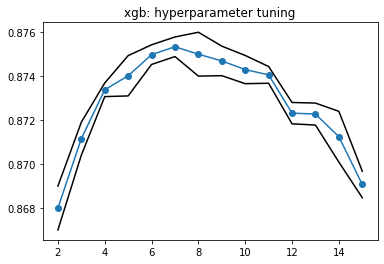

In [ ]:
feat_to_use = num_feat+cat_feat
nb = np.linspace(2,15,14)
parameter_tuning = pd.DataFrame([],index = nb,columns = ['score','std'])
for n in nb:
    n = int(n)
    print(n, end = '            \r')
    catb = predictor('catboost',{'resample': True, 'nb_samples': 5, 'data_set_portion': 0.2, 'n_estimators': 100,'max_depth': n})
    catb.train(X_train[feat_to_use],X_train['Response'])
    parameter_tuning.loc[n,['score','std']] = catb.validate(X_train[feat_to_use],X_train['Response']).loc['mean/std',:].values
parameter_tuning = parameter_tuning.sort_index()
plt.scatter(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score']+parameter_tuning['std'], color = 'k')
plt.plot(parameter_tuning.index,parameter_tuning['score']-parameter_tuning['std'], color = 'k')
plt.title('xgb: hyperparameter tuning')
print()
display(parameter_tuning.sort_values('score',ascending = False).head(5))

1.0             


,score,std
0.89,0.875867,0.000415
0.67,0.875451,0.000819
0.45,0.875362,0.000867
0.78,0.875182,0.00051
0.56,0.87505,0.00035


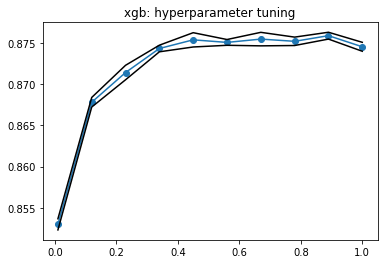

In [ ]:
feat_to_use = num_feat+cat_feat
nb = np.linspace(0.01,1,10)
parameter_tuning = pd.DataFrame([],index = nb,columns = ['score','std'])
for n in nb:
    print(n, end = '            \r')
    catb = predictor('catboost',{'resample': True, 'nb_samples': 5, 'data_set_portion': 0.2, 'n_estimators': 100,'max_depth': 7, 'eta': n})
    catb.train(X_train[feat_to_use],X_train['Response'])
    parameter_tuning.loc[n,['score','std']] = catb.validate(X_train[feat_to_use],X_train['Response']).loc['mean/std',:].values
parameter_tuning = parameter_tuning.sort_index()
plt.scatter(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score'])
plt.plot(parameter_tuning.index,parameter_tuning['score']+parameter_tuning['std'], color = 'k')
plt.plot(parameter_tuning.index,parameter_tuning['score']-parameter_tuning['std'], color = 'k')
plt.title('xgb: hyperparameter tuning')
print()
display(parameter_tuning.sort_values('score',ascending = False).head(5))

In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
catb = predictor('catboost',{'resample': True,'nb_samples': 10, 'data_set_portion': 0.25, 'n_estimators': 600,'max_depth': 7, 'eta': 0.89})
catb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],catb.predict(X_val[feat_to_use])))
catb.validate(X_train[feat_to_use],X_train['Response'])

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.8773988222879445


,score,seed
0,0.866716,0
1,0.865725,1
2,0.866572,2
3,0.865835,3
4,0.86689,4
5,0.866174,5
6,0.865957,6
7,0.865604,7
8,0.867658,8
9,0.866885,9


In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
catb = predictor('catboost',{'resample': True,'nb_samples': 10, 'data_set_portion': 0.25, 'n_estimators': 250,'max_depth': 7, 'eta': 0.89})
catb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],catb.predict(X_val[feat_to_use])))
pd.DataFrame(catb.predict(test[feat_to_use]),index = test.index,columns = ['Response']).to_csv('submission.csv')
print('Submitted, score:',0.87918)

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.8787067852855914
Submitted, score: 0.87918


In [ ]:
feat_to_use = num_feat+cat_feat
print(feat_to_use)
catb = predictor('catboost',{'resample': True,'nb_samples': 10, 'data_set_portion': 0.25, 'n_estimators': 600,'max_depth': 7, 'eta': 0.89})
catb.train(X_train[feat_to_use],X_train['Response'])
print('My score:',roc_auc_score(X_val['Response'],catb.predict(X_val[feat_to_use])))
pd.DataFrame(catb.predict(test[feat_to_use]),index = test.index,columns = ['Response']).to_csv('submission.csv')
print('Submitted, score:',0.87770)

['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']
My score: 0.877509046300064
Submitted, score: 0.8777


# Keras

In [1]:
# rerun this in order to include more one-hot-encoding categories
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
import warnings
from catboost import CatBoostClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import initializers
import tensorflow as tf

train = pd.read_csv('train.csv').set_index('id')
test = pd.read_csv('test.csv').set_index('id')

cat_feat = ['Gender', 'Driving_License', 'Vehicle_Damage','Region_Code','Policy_Sales_Channel','Previously_Insured']
binary_cat_feat = ['Gender', 'Driving_License', 'Vehicle_Damage','Previously_Insured']
num_feat = ['Annual_Premium', 'Age', 'Vehicle_Age','Vintage']

train.loc[train['Vehicle_Age'] == '< 1 Year', 'Vehicle_Age'] = 0
train.loc[train['Vehicle_Age'] == '1-2 Year', 'Vehicle_Age'] = 1
train.loc[train['Vehicle_Age'] == '> 2 Years', 'Vehicle_Age'] = 2
train.loc[train['Vehicle_Damage'] == 'Yes','Vehicle_Damage'] = 1
train.loc[train['Vehicle_Damage'] == 'No','Vehicle_Damage'] = 0
train.loc[train['Gender'] == 'Female','Gender'] = 1
train.loc[train['Gender'] == 'Male','Gender'] = 0

test.loc[test['Vehicle_Age'] == '< 1 Year', 'Vehicle_Age'] = 0
test.loc[test['Vehicle_Age'] == '1-2 Year', 'Vehicle_Age'] = 1
test.loc[test['Vehicle_Age'] == '> 2 Years', 'Vehicle_Age'] = 2
test.loc[test['Vehicle_Damage'] == 'Yes','Vehicle_Damage'] = 1
test.loc[test['Vehicle_Damage'] == 'No','Vehicle_Damage'] = 0
test.loc[test['Gender'] == 'Female','Gender'] = 1
test.loc[test['Gender'] == 'Male','Gender'] = 0

# make 6 categories ouf of Regional_Code (keep the 5 most common) and one-hot-encode them.
nb_categories = 40
temp = pd.concat([train,test])
temp['rc'] = temp['Region_Code'].astype(int)
temp.loc[~(temp['rc'].isin(train['Region_Code'].value_counts().index[:nb_categories])),'rc'] = 100
temp = temp.join(pd.get_dummies(temp['rc'],prefix = 'rc')).drop(columns = ['rc_100','rc'])
train = temp.loc[train.index,:].copy()
test = temp.loc[test.index,:].copy()
del temp

# make 4 categories ouf of Policy_Sales_Channel (keep the 3 most common) and one-hot-encode them.
nb_categories = 100
temp = pd.concat([train,test])
temp['psc'] = temp['Policy_Sales_Channel'].astype(int)
temp.loc[~(temp['psc'].isin(train['Policy_Sales_Channel'].value_counts().index[:nb_categories])),'psc'] = 200
temp = temp.join(pd.get_dummies(temp['psc'],prefix = 'psc')).drop(columns = ['psc_200','psc'])
train = temp.loc[train.index,:].copy()
test = temp.loc[test.index,:].copy()
del temp

middle_age = 43.5
n = 0.1
temp = (train['Age'])**n - (middle_age)**n
train['age_lin'] = np.abs(temp)**1.2
temp = (test['Age'])**n - (middle_age)**n
test['age_lin'] = np.abs(temp)**1.2

X_train, X_val, _, _ = train_test_split(train, train['Response'], test_size=0.2)

#print('Remove outliers:',len(X_train[X_train['Annual_Premium']<100000])/len(X_train))
#X_train = X_train[X_train['Annual_Premium']<100000].copy()

print('Remove 1 faulty data point. The Region_Code is an integer.')
X_train = X_train[X_train['Region_Code'] != 39.2]

2024-07-26 16:15:22.360670: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Remove 1 faulty data point. The Region_Code is an integer.


Compute the XGB prediction to provide it as a feature for the neural net.

In [3]:
feat_to_use = num_feat+cat_feat
print('xgb', feat_to_use)
xgb = predictor('xgb',{'resample': True, 'nb_samples': 10, 'data_set_portion': 0.25, 'n_estimators': 250, 'max_depth': 7, 'gamma': 4.445556, 'min_child_weight': 68.575714})
xgb.train(X_train[feat_to_use],X_train['Response'])

train['xgb_pred'] = xgb.predict(train[feat_to_use])
test['xgb_pred'] = xgb.predict(test[feat_to_use])
X_train['xgb_pred'] = train.loc[X_train.index,'xgb_pred']
X_val['xgb_pred'] = train.loc[X_val.index,'xgb_pred']

xgb ['Annual_Premium', 'Age', 'Vehicle_Age', 'Vintage', 'Gender', 'Driving_License', 'Vehicle_Damage', 'Region_Code', 'Policy_Sales_Channel', 'Previously_Insured']


In [54]:
if 'history_df' in dir():
    del history_df

feat_to_use_net = num_feat+cat_feat + ['age_lin','xgb_pred']+[c for c in X_train.columns if c.startswith('rc')] + [c for c in X_train.columns if c.startswith('psc')]
#feat_to_use_net = num_feat+cat_feat + ['age_lin']+[c for c in X_train.columns if c.startswith('rc')] + [c for c in X_train.columns if c.startswith('psc')]
feat_to_scale = num_feat+['Region_Code','Policy_Sales_Channel','age_lin']
X_net = X_train[feat_to_use_net].astype(float).copy()
y_net = X_train['Response'].astype(float).copy()
rus = RandomUnderSampler()
X_net, y_net = rus.fit_resample(X_net, y_net)
scaler = StandardScaler()
scaler.fit(X_net[feat_to_scale])
X_net[scaler.get_feature_names_out()] = scaler.transform(X_net[feat_to_scale].copy())

X_net_val = X_val[feat_to_use_net].astype(float).copy()
y_net_val = X_val['Response'].astype(float).copy()
X_net_val[scaler.get_feature_names_out()] = scaler.transform(X_net_val[feat_to_scale].copy())

std = 0.1
mean = 0.0
activation = 'tanh'
model = Sequential()
model.add(Dense(16, input_shape=(np.shape(X_net)[1],), activation=activation,bias_initializer=initializers.RandomNormal(stddev=std),kernel_initializer=initializers.RandomNormal(mean = mean,stddev=std)))
model.add(Dense(12, activation=activation,bias_initializer=initializers.RandomNormal(stddev=std),kernel_initializer=initializers.RandomNormal(stddev=std)))
model.add(Dense(8, activation=activation,bias_initializer=initializers.RandomNormal(stddev=std),kernel_initializer=initializers.RandomNormal(stddev=std)))
model.add(Dense(4, activation=activation,bias_initializer=initializers.RandomNormal(stddev=std),kernel_initializer=initializers.RandomNormal(stddev=std)))
model.add(Dense(2, activation=activation,bias_initializer=initializers.RandomNormal(stddev=std),kernel_initializer=initializers.RandomNormal(stddev=std)))
model.add(Dense(1, activation = 'sigmoid', bias_initializer=initializers.RandomNormal(stddev=std),kernel_initializer=initializers.RandomNormal(stddev=std)))

model.compile(optimizer='adam',loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc')])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 16)                784       
                                                                 
 dense_29 (Dense)            (None, 12)                204       
                                                                 
 dense_30 (Dense)            (None, 8)                 104       
                                                                 
 dense_31 (Dense)            (None, 4)                 36        
                                                                 
 dense_32 (Dense)            (None, 2)                 10        
                                                                 
 dense_33 (Dense)            (None, 1)                 3         
                                                                 
Total params: 1141 (4.46 KB)
Trainable params: 1141 (4

In [ ]:
X_net = train[feat_to_use_net].astype(float).copy()
y_net = train['Response'].astype(float).copy()
rus = RandomUnderSampler()
X_net, y_net = rus.fit_resample(X_net, y_net)
scaler = StandardScaler()
scaler.fit(X_net)
X_net[scaler.get_feature_names_out()] = scaler.transform(X_net.copy())

In [55]:
#history = model.fit(X_net.values, y_net.values, epochs=40, batch_size= 50000)#,validation_split = 0.2)
#history = model.fit(X_net.values, y_net.values, epochs=20, batch_size=10000,validation_split = 0.2)
#history = model.fit(X_net.values, y_net.values, epochs=500, batch_size=10000,validation_data=(X_net_val, y_net_val))
history = model.fit(X_net.values, y_net.values, epochs=200, batch_size=500,validation_data=(X_net_val, y_net_val))
#history = model.fit(X_net.values, y_net.values, epochs=10, batch_size=1000)#,validation_split = 0.2)
#history = model.fit(X_net.values, y_net.values, epochs=10, batch_size=100)#,validation_split = 0.2)
#history = model.fit(X_net.values, y_net.values, epochs=40, batch_size=100,validation_data=(X_net_val, y_net_val))
if not('history_df' in dir()):
    history_df = pd.DataFrame.from_dict(history.history)
    history_df.index = history.epoch
else:
    temp = pd.DataFrame.from_dict(history.history)
    temp.index = history.epoch + np.max(history_df.index+1)
    history_df = pd.concat([history_df,temp])

Epoch 1/200
4526/4526 [==============================] - 13s 3ms/step - loss: 0.4245 - auc: 0.8698 - val_loss: 0.4303 - val_auc: 0.8814
Epoch 2/200
4526/4526 [==============================] - 9s 2ms/step - loss: 0.3938 - auc: 0.8827 - val_loss: 0.4330 - val_auc: 0.8821
Epoch 3/200
4526/4526 [==============================] - 10s 2ms/step - loss: 0.3931 - auc: 0.8831 - val_loss: 0.4116 - val_auc: 0.8822
Epoch 4/200
4526/4526 [==============================] - 9s 2ms/step - loss: 0.3930 - auc: 0.8833 - val_loss: 0.4140 - val_auc: 0.8819
Epoch 5/200
4526/4526 [==============================] - 9s 2ms/step - loss: 0.3929 - auc: 0.8833 - val_loss: 0.4045 - val_auc: 0.8820
Epoch 6/200
4526/4526 [==============================] - 9s 2ms/step - loss: 0.3928 - auc: 0.8833 - val_loss: 0.4369 - val_auc: 0.8823
Epoch 7/200
4526/4526 [==============================] - 10s 2ms/step - loss: 0.3927 - auc: 0.8835 - val_loss: 0.3978 - val_auc: 0.8820
Epoch 8/200
4526/4526 [=============================

train: 0.389425 0.884797
val  : 0.397771 0.883141


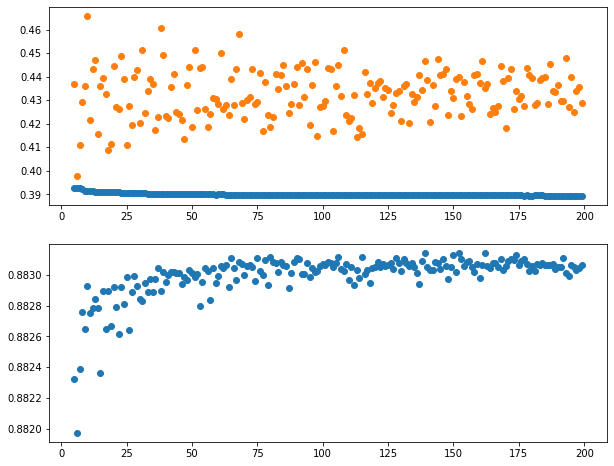

In [58]:
# 2633 parameters [16,8,4,2]) feature resampling included, mean = 0, a lot more one hot encoded features, include xgb prediction
fig, axs = plt.subplots(2)
fig.set_figheight(8)
fig.set_figwidth(10)

ind = 5
temp = history_df[history_df.index >= ind].copy()

axs[0].scatter(temp.index,temp['loss'])
axs[0].scatter(temp.index,temp['val_loss'])
#axs[0].set_ylim([0.88,1])
#axs[0].set_yscale('log')
#axs[1].scatter(temp.index,temp['auc'])
axs[1].scatter(temp.index,temp['val_auc'])
#axs[1].plot([temp.index.min(),temp.index.max()],[0.88,0.88],color = 'k')
#axs[1].plot([temp.index.min(),temp.index.max()],[0.89,0.89],color = 'k')
#axs[1].set_ylim([-0.02,0.07])
print('train:',round(temp['loss'].min(),6),round(temp['auc'].max(),6))
print('val  :',round(temp['val_loss'].min(),6),round(temp['val_auc'].max(),6))

In [ ]:
roc_auc_score(X_val['Response'],model.predict(scaler.transform(X_val[scaler.get_feature_names_out()].copy()).astype(float)))

71905/71905 [==============================] - 67s 923us/step


0.881383492503031

In [ ]:
pd.DataFrame(model.predict(scaler.transform(test[scaler.get_feature_names_out()].copy()).astype(float)),index = test.index,columns = ['Response']).to_csv('submission.csv')
print('Submitted, score:',0.88235)

239684/239684 [==============================] - 227s 948us/step
